# Test Results Comparison - YouTube Spam Detection

This notebook compares test set results across the experiments saved


## Setup and loading


In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)

from spam_ham_detector.config import RESULTS_DIR


sns.set_theme(style='whitegrid')

## Results Overview


### Available experiments


In [2]:
test_paths = sorted(
    RESULTS_DIR.glob('*/test.csv'),
    key=lambda p: p.relative_to(RESULTS_DIR).parts,
)

pd.DataFrame(
    {
        'experiment': path.parent.name,
        'rows': len(df := pd.read_csv(path)),
        'columns': ', '.join(df.columns),
    }
    for path in test_paths
)

,experiment,rows,columns
0,bert-albert-finetuned,352,"text, y_true, y_pred, y_scores"
1,bert-distilbert-finetuned,352,"text, y_true, y_pred, y_scores"
2,lr-ft-advanced,352,"text, y_true, y_pred, y_scores"
3,lr-ft-simple,352,"text, y_true, y_pred, y_scores"
4,lr-sbert-minilm,352,"text, y_true, y_pred, y_scores"
5,lr-sbert-mpnet,352,"text, y_true, y_pred, y_scores"
6,lr-tfidf-advanced,352,"text, y_true, y_pred, y_scores"
7,lr-tfidf-simple,352,"text, y_true, y_pred, y_scores"


### Metrics summary


In [3]:
rows = []
for path in test_paths:
    df = pd.read_csv(path)

    rows.append({
        'experiment': path.parent.name,
        'samples': len(df),
        'accuracy': accuracy_score(df['y_true'], df['y_pred']),
        'precision': precision_score(df['y_true'], df['y_pred']),
        'recall': recall_score(df['y_true'], df['y_pred']),
        'f1': f1_score(df['y_true'], df['y_pred']),
        'roc_auc': roc_auc_score(df['y_true'], df['y_scores']),
    })

summary = pd.DataFrame(rows).sort_values('f1', ascending=False).round(2)
summary


,experiment,samples,accuracy,precision,recall,f1,roc_auc
1,bert-distilbert-finetuned,352,0.98,0.98,0.98,0.98,0.99
0,bert-albert-finetuned,352,0.97,0.96,0.98,0.97,1.00
5,lr-sbert-mpnet,352,0.95,0.96,0.93,0.94,0.98
4,lr-sbert-minilm,352,0.94,0.96,0.92,0.94,0.98
2,lr-ft-advanced,352,0.89,0.87,0.90,0.89,0.94
3,lr-ft-simple,352,0.89,0.87,0.90,0.89,0.94
7,lr-tfidf-simple,352,0.88,0.91,0.84,0.87,0.95
6,lr-tfidf-advanced,352,0.88,0.91,0.82,0.86,0.94


## Model Comparison


### Metric ranking


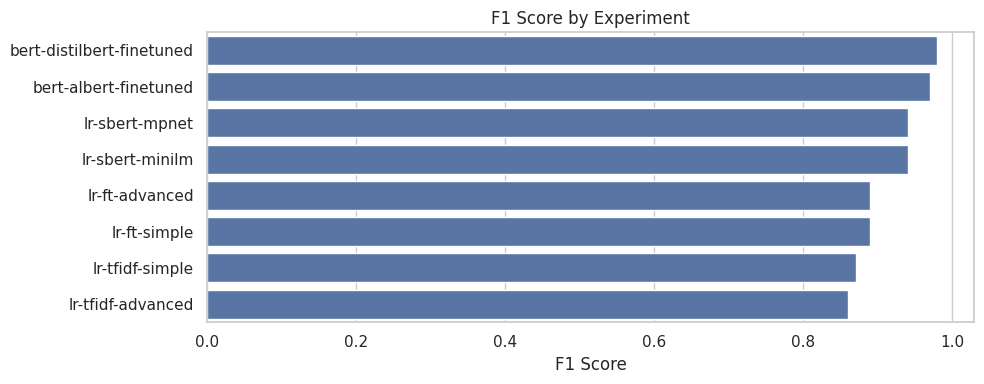

In [4]:
fig, axes = plt.subplots(figsize=(10, 4))

sns.barplot(data=summary, y='experiment', x='f1', ax=axes)
axes.set_title('F1 Score by Experiment')
axes.set_xlabel('F1 Score')
axes.set_ylabel('')

plt.tight_layout()
plt.show()


### Confusion matrices

In [5]:
def calculate_cm(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return np.array([[tp, fp], [fn, tn]])

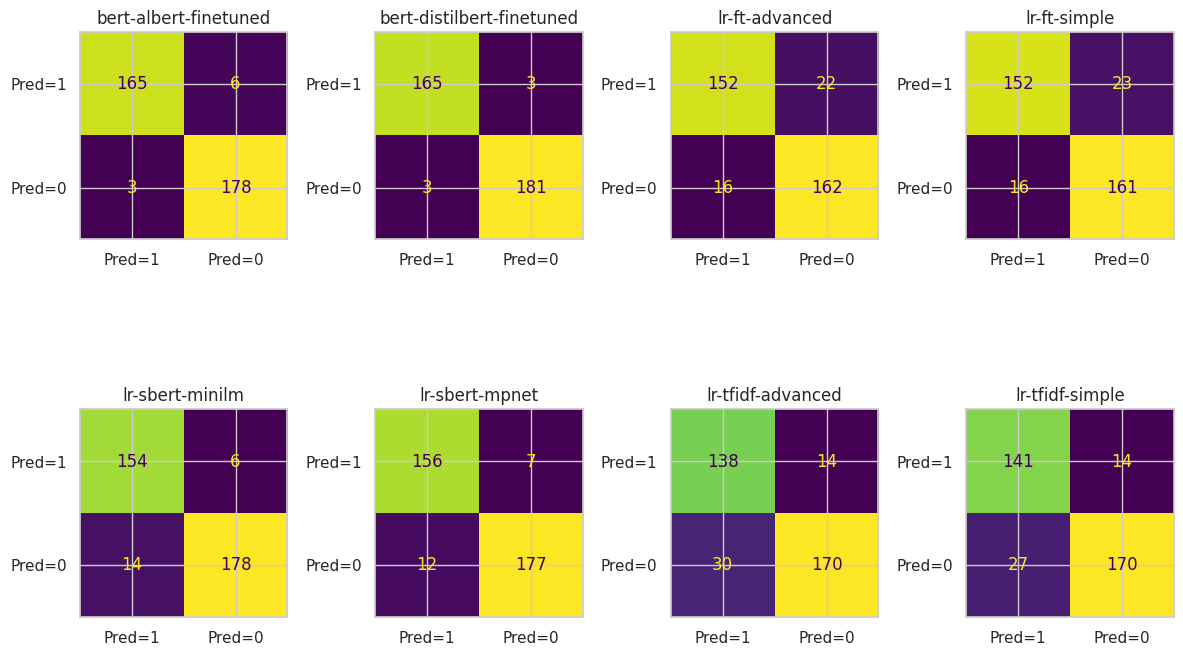

In [6]:
cols = 4
rows = math.ceil(len(test_paths) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
axes = np.atleast_1d(axes).ravel()

for ax, p in zip(axes, test_paths):
    df = pd.read_csv(p)
    cm = calculate_cm(df['y_true'], df['y_pred'])

    disp = ConfusionMatrixDisplay(cm, display_labels=['Pred=1', 'Pred=0'])
    disp.plot(ax=ax, values_format='d', colorbar=False)

    ax.set_title(p.parent.name)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()


### ROC AUC Curves

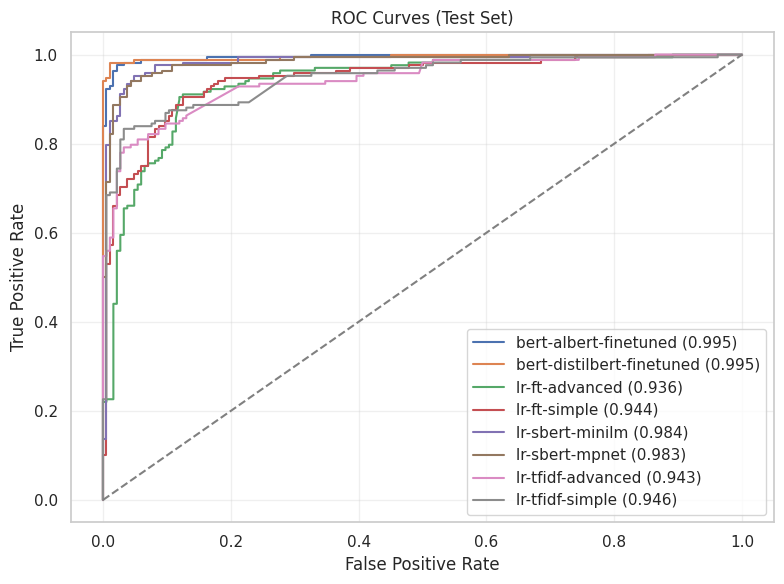

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

for name, df in ((p.parent.name, pd.read_csv(p)) for p in test_paths):
    fpr, tpr, _ = roc_curve(df["y_true"], df["y_scores"])
    ax.plot(fpr, tpr, label=f"{name} ({roc_auc_score(df['y_true'], df['y_scores']):.3f})")

ax.plot([0, 1], [0, 1], "--", color="gray")
ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title="ROC Curves (Test Set)")
ax.legend(loc="lower right")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()
